# Assignment 1d Notebook: Island Model EA
This notebook will guide you through Assignment 1d: building an island model EA. This assignment builds on the EA code you wrote in assignments 1b and 1c; therefore, you should copy over the following files:
* 1a_notebook.ipynb
* 1b_notebook.ipynb
* 1c_notebook0.ipynb
* 1c_notebook1.ipynb
* base_evolution.py
* bridge_population_evaluation.py
* linear_genotype.py
* selection.py
* domination.py

*Be careful* to not copy over functions relating to the provided fitness functions or bridge structures (files you shouldn't have modified anyways). We may have changed those and we want you to have the versions that were provided with this repo.

As usual, be sure to **read all of this notebook** and you can start by executing the next cell.

In [ ]:
# Configure this notebook to automatically reload modules as they're modified
# https://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore') # hopefully stop any pedantic warnings

import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (12.0, 12.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'

print('The first cell has been executed!')

## Island Models
As discussed in lectures, an island model EA is an EA where multiple populations evolve in relative isolation, and exchange limited amounts of genetic material (via migration) every few generations. Thankfully, these isolated populations are exactly what you implemented in 1b! That means we can reuse your `BaseEvolutionPopulation` class, and your `basic_population_evaluation` function. To make it so implementing island models is as straightforward as possible, we've provided `island_model.py`, which contains a partially-complete class for you to finish. Only four things need to be changed to implement island models:
* Code to initialize the data structure that will contain the individual islands
* Code to iterate through your data structure, so your notebook code can work with any data structure
* Code to perform migration between the islands
* Changes to the EA initialization and generational loop to handle multiple `BaseEvolutionPopulation` populations

You will be tasked with implementing several different topologies, and these first three points will need to be implemented separately for each topology. We've formulated these requirements so that the final point (your actual EA loop in the notebook) should work for any topology in the assignment. We will first discuss the topologies you will implement before walking through the `island_model.py` file. We have provided code that will handle the simplest topology for you, which you should use as an example.

**NOTE:** You are free to make any changes you want to `island_model.py`, but we strongly recommend only changing code where there is a `TODO` comment unless you intend to attempt a RED deliverable that might require changes to the class. In that event, try to keep changes to only what's necessary, explain your changes thoroughly and clearly, and *please pretty please don't make grading miserable*. Your final `island_model.py` file should work seamlessly on each and every attempted deliverable. Similarly, you may make changes to the structure of the config (this will absolutely be necessary for heterogeneous islands) but need to keep things in a sensible format.

### Required Topologies
In this assignment you will be using four different topologies. The first one, `uni_circle`, has been implemented for you. The second, `bi_circle`, is partially-implemented. The remaining two, `all_to_all` and `toroid` are left for you to implement.

#### uni_circle
This topology is a circle where migrations only occur in one direction. A `uni_circle` of size 4 would look like:
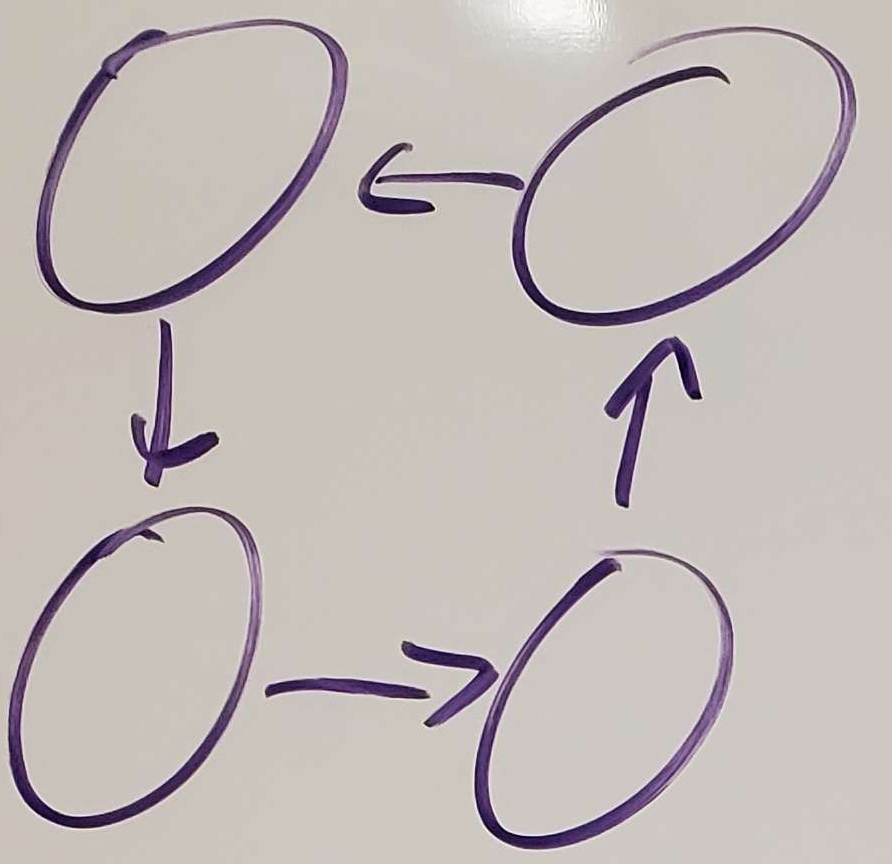

#### bi_circle
This topology is a circle where migrations occur in both directions. A `bi_circle` of size 4 would look like:
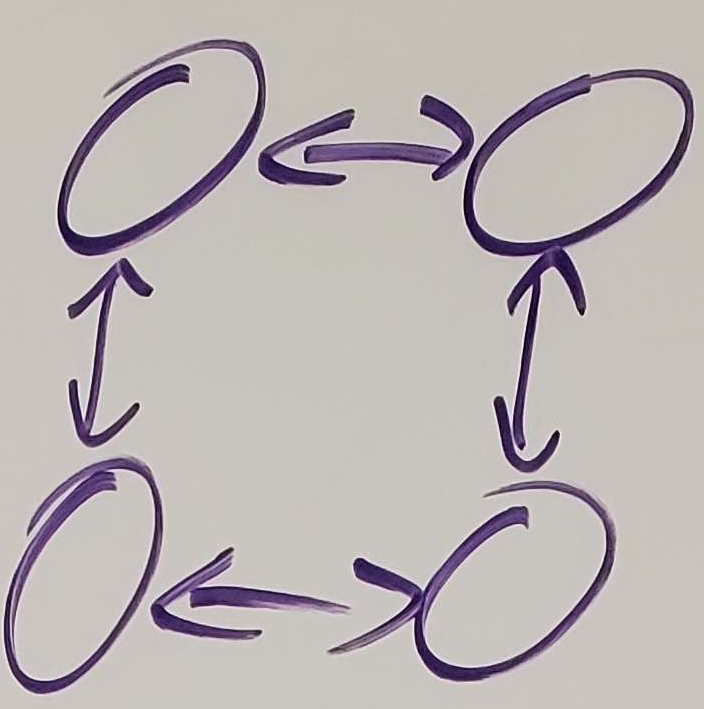

#### all_to_all
This topology has migrations in both directions between every pair of islands (i.e., a complete graph or clique). An `all_to_all` topology of size 4 would look like:
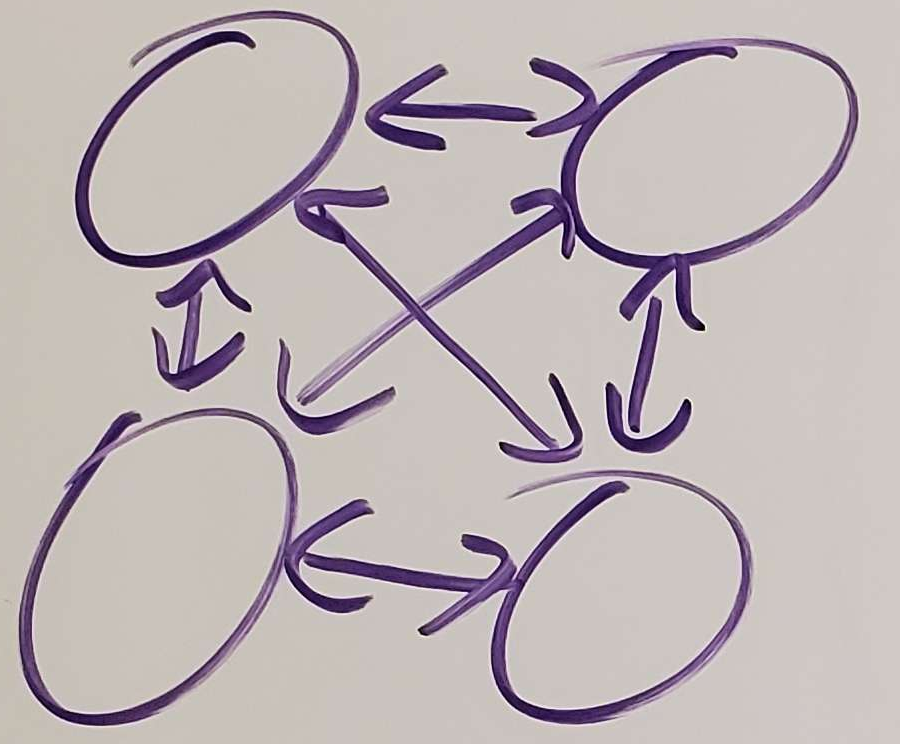

#### toroid
This topology is a 2-dimensional grid (i.e., rectangle) that wraps around on both axes. That is, migration can occur in each cardinal direction (up, down, left, right), and islands on the boundary of a dimension can migrate with islands on the other boundary of that dimension, like an old arcade game (i.e., Pacman) where walking off one side puts you on the other side. That might sound a bit confusing but it should be quite easy to implement. (Note on the name: In mathematical terms this is called a toroid, which is essentially a donut. If you're confused about how wrapping a rectangle around both axes creates a donut, [watch this gif from wikipedia](https://en.wikipedia.org/wiki/Torus#/media/File:Torus_from_rectangle.gif).) A 3x3 `toroid` would look like:
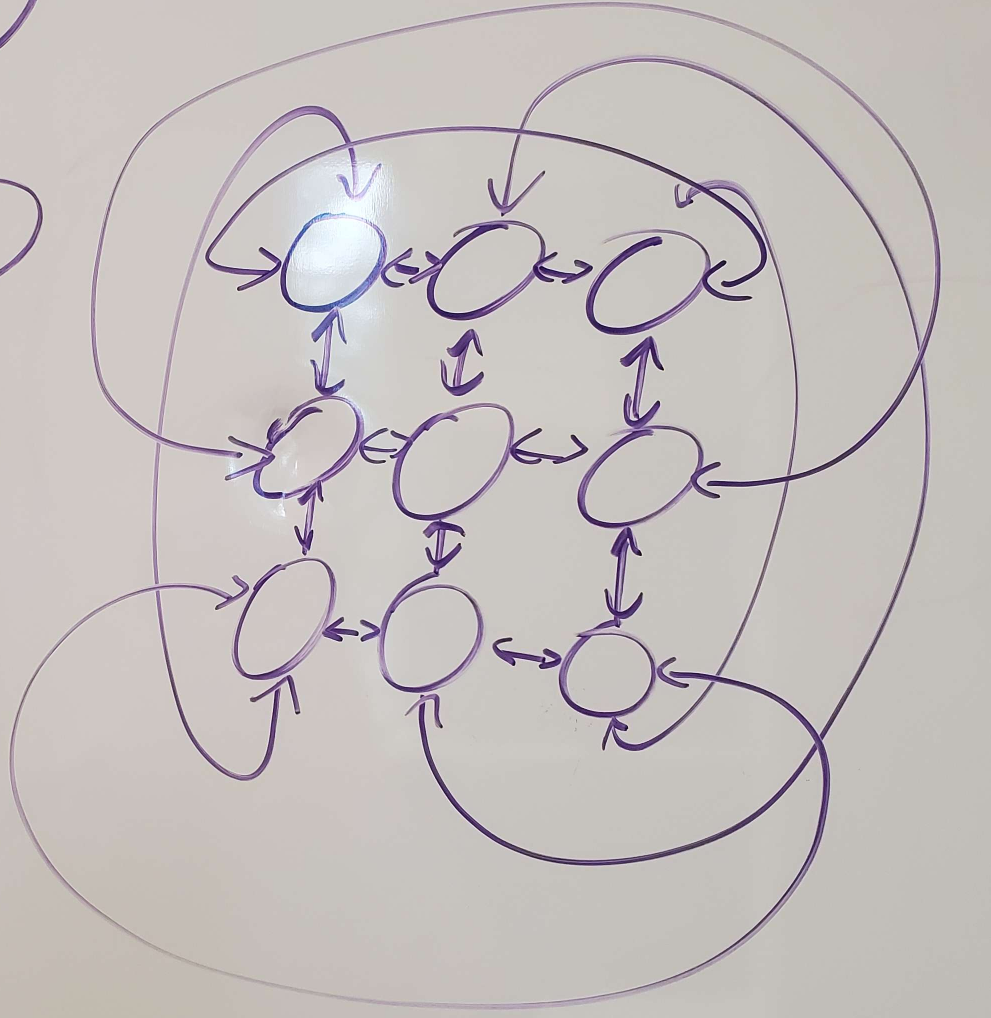

### Initialization
The `IslandModel.__init__` method is partially filled-out for you. We've provided code that will initialize a sensible data structure for the circular topologies:
```python
def __init__(self, topology, size, interval, migrant_selection, num_migrants,
                     migrant_selection_kwargs = dict(), EA_configs = dict(), **kwargs):
    ...
    if self.topology == 'uni_circle' or self.topology == 'bi_circle':
        ...
        # This is given for you to use as an example.
        # The other topologies may have better representations,
        # don't just copy-paste this without thinking.
        # You can use any data structure(s) with any name(s) you want.
        self.islands = [BaseEvolutionPopulation(**EA_configs, **kwargs) for _ in range(size)]
```
While this should serve as an example of how to initialize the `BaseEvolutionPopulation` objects, and store them as a list, you should not simply copy-paste this code for the other topologies. The other topologies may have more reasonable data structures -- you should think about what would be best, and implement them however you see fit.

Note the `size` variable is used here to define the number of islands. In the `uni_circle`, `bi_circle`, and `all_to_all` topologies, this is a single number. In the `toroid` topology, this should be a pair of values defining the size in each dimension (in the example `toroid` shown in the previous section, `size == (3, 3)`).

### Iteration
The `IslandModel.__iter__` method defines how to iterate through your custom data structures. This technique may appear slightly advanced, but taking this approach allows you to write an outermost EA function that's agnostic to the underlying island topology. To mitigate the fact that you may be unfamiliar with this technique, we have provided code that will handle this for the circular topologies:
```python
def __iter__(self):
    # Filling this class out will let your EA loop in the notebook handle
    # any topology interchangeably. It should iterate through every island
    # in your topology, returning each one a single time. See the notebook
    # for a more in-depth explanation of how this can be accomplished.

    if self.topology == 'uni_circle' or self.topology == 'bi_circle':
        # We put a custom generator here to serve as an example; this could
        # just as easily have been written using the built-in list iterator:
        # yield from self.islands
        for island in self.islands:
            yield island
```
Since `self.islands` was simply a list in this topology, we could also have just used the `list`'s built-in iterator:
```python
yield from self.islands
```
We opted for the use of `yield` to create a [generator function](https://wiki.python.org/moin/Generators) since this will likely be necessary for the `toroid` topology. `yield` behaves like a `return` statement, but the function's state is saved and will be resumed on the next call (as long as the calling code is iterating through the object -- it's a bit more complicated under the hood, but you can ignore the details and it will just work like any iterable data structure). We can use this technique to handle data structures that need more complex traversal, and might even involve multiple distinct member variables:

In [ ]:
class IterTester():
    def __init__(self):
        self.letters = ['a', 'b', 'c', 'd']
        self.multi_dimensional = [[(j, i) for i in range(3)] for j in range(3)]
        self.special_single_island = 'special'
    
    def __iter__(self):
        yield from self.letters
        # equivalent to:
        # for letter in self.letters:
        #     yield letter

        for dimension in self.multi_dimensional:
            for value in dimension:
                yield value
        # equivalent to:
        # for dimension in self.multi_dimensional:
        #     yield from dimension
        
        yield self.special_single_island

tester = IterTester()

We can now easily iterate over the object despite it being a more complex underlying data structure:

In [ ]:
for value in tester:
    print(value)

Including things like list comprehensions:

In [ ]:
print([value for value in tester])

But we can't get specific individual values, or use `len()` (unless you define `__getitem__` and `__len__`). Fortunately, you don't have any reason to need that functionality for this assignment.

In [ ]:
try:
    print(tester[0])
except:
    print('Does not support indexing')

try:
    print(len(tester))
except:
    print('Does not support length')

del tester, IterTester

You can write your iteration however you see fit, but your method should iterate over every `BaseEvolutionPopulation` in your model exactly once.

### Migration
The `IslandModel.migrate` method performs the actual migration between islands in your topology. We have provided a `get_migrants` method that you should use as part of this process. `get_migrants` takes as input a `BaseEvolutionPopulation`, a number of migrants to select, and will select that many migrants using your existing survival selection algorithms, while removing the selected individuals from the population:

In [ ]:
from island_model import get_migrants
from base_evolution import BaseEvolutionPopulation
from linear_genotype import LinearGenotype
from selection import *
from snake_eyes import read_config

config = read_config('./configs/green1d_uni_circle_config.txt', globalVars=globals(), localVars=locals())

island = BaseEvolutionPopulation(**config['EA_configs'], **config)
island.population = [LinearGenotype() for _ in range(10)]
for i in range(len(island.population)):
    island.population[i].fitness = i * 100000

print('Fitness of each individual in the population:')
print([individual.fitness for individual in island.population])
print()

migrants = get_migrants(island, 2, truncation)
print('Fitness of 2 individuals selected for migration using truncation:')
print([migrant.fitness for migrant in migrants])
print()

print('Fitness of individuals in the population after migrant selection:')
print('(Note get_migrants shuffles your population)')
print([individual.fitness for individual in island.population])
print()

migrants = get_migrants(island, 2, k_tournament_without_replacement, {'k':2})
print('Fitness of 2 individuals selected for migration using k-tournaments without replacement:')
print([migrant.fitness for migrant in migrants])
print()

print('Fitness of individuals in the population after migrant selection:')
print('(Note get_migrants shuffles your population)')
print([individual.fitness for individual in island.population])
print()

del config, island, migrants

We have again provided example code of how to perform migration (this time only for `uni_circle`, rather than both `uni_circle` and `bi_circle`):
```python
def migrate(self):
    # Only migrate with a frequency based on our interval.
    self.generation_count += 1
    if self.generation_count != self.interval:
        return
    self.generation_count = 0

    # Migrants are pre-selected before any movement occurs to ensure no individual
    # is selected to migrate multiple times in a row. migrants is a dictionary
    # mapping each island to the migrants that were selected & removed from it.
    # Each island's migrants are shuffled, so feel free to just iterate through
    # the list for topologies where each island has multiple out-edges.
    # DO NOT RANDOMLY SAMPLE FROM THE MIGRANT LISTS
    migrants = {island:get_migrants(island, self.num_migrants, self.migrant_selection,
                               self.migrant_selection_kwargs) for island in self}

    if self.topology == 'uni_circle':
        for i in range(len(self.islands)):
            # Tip: Many Python data structures allow negative indices,
            #      and will cleanly wrap around to the back of the array.
            #      i.e., self.islands[-1] is self.islands[len(self.islands)-1]
            self.islands[i].population += migrants[self.islands[i-1]]
```

Migration should only occur once per `interval` generations, but notice the four lines at the top -- you should call this function once per generation and it will automatically determine whether migration should occur. Your outer EA loop doesn't need to concern itself at all with the migration process, the interval, or if migration even actually happened.

**IMPORTANT:** As shown in the initialization of the `migrants` dictionary, `num_migrants` defines the number of migrants that should be selected from each island. In addition, for this assignment, we have the **strict** requirements that the total number of migrants leaving each island is identical to the total number of migrants arriving at that island, and that all islands send and receive the same number of migrants. This helps ensure the population size at each island is unchanged by the migration process. We would have preferred to let your reproduction and survival selection *just work* to bring population sizes back to the correct values, but that requires careful consideration of several interrelated configurable parameters. Instead, with these requirements, you only need to make sure your `num_migrants` value is a multiple of the number of edges leaving each island (the exact per-topology requirements can be found as `assert` statements in `__init__`). You may drop these requirements if implementing a RED deliverable, though you need to be careful to make sure your implementation doesn't break, and demonstrate thorough comprehension of any peculiar ways your implementation and/or configurable parameters behave (make it clear to us that you know what you're doing and that your implementation's correctness wasn't just a matter of luck). For example, if migration changes the number of individuals in an island, explain how you managed to accomodate for this behavior in your report.

Side note: we adamantly say not to sample from the migrant lists because in the worst case you might just do it incorrectly (if done with replacement) and in the best case your algorithm will be needlessly complicated, and `O(n^2)` (if done without replacement by removing sampled individuals). We've already shuffled each list for you, and iterating through a shuffled list is equivalent to sampling without replacement.

### Changes to the EA loop
The EA loop for this assignment will look pretty similar to the loop from 1b, but you need to iterate through your island model to evolve each island individually. The initialization (but not evaluation) of each population was handled in the `IslandModel.__init__` method, so that doesn't need any iteration:

In [ ]:
from bridge_population_evaluation import *
from island_model import IslandModel

config = read_config('./configs/green1d_uni_circle_config.txt', globalVars=globals(), localVars=locals())

example_island_model = IslandModel(**config['island_model_configs'], **config)
example_island_model.evaluations = 0

Thanks to the fact that we defined `IslandModel.__iter__`, we can evaluate each island's initial population with no concern for the underlying topology:

In [ ]:
for island in example_island_model:
    basic_population_evaluation(island.population, **config['fitness_kwargs'])
    example_island_model.evaluations += len(island.population)

Similarly, the code to handle one generation of evolution for each island is basically the same as 1b, but iterated over the islands:

In [ ]:
# This code would go inside your generational loop
example_island_model.migrate()
for island in example_island_model:
    children = island.generate_children()
    basic_population_evaluation(children, **config['fitness_kwargs'])
    example_island_model.evaluations += len(children)
    island.population += children
    island.survival()

del example_island_model, config, children

Your island model loop should be very similar to the standard EA loop, but with a line to call the `migrate` method, and with an inner loop that iterates over islands. We don't require any special care to make sure you stop at exactly 5000 evaluations -- you can just use the same termination condition, and check it after running a generation on all the islands (there's no need to check for termination after each individual island's generation). Implement it here:

In [ ]:
from math import inf

def island_model_EA_search(number_evaluations, config_filename):
    # Parse the config and implement your EA here.
    # Feel free to focus on implementation first and then return for data collection.
    pass

In [ ]:
# calling your function
print(island_model_EA_search(5000, './configs/green1d_uni_circle_config.txt'))

# Experiments

Now that you have a function capable of performing a single run of your island model EA, perform 4 30-run experiments: one experiment for each of the required topologies. Be sure to tune the parameters in each config and save the best parameters you find. You may copy your tuned parameters from past assignments as a starting point. For this assignment, we have no set performance we expect you to reach through tuning though you are expected to explore parameter modifications (particularly the new parameters introduced with this assignment) in a way that indicates comprehension of their behavior.

## Data collection
For each generation of each run, log the mean and best raw fitness of the current population as well as the number of fitness evaluations performed so far (including the initial population). Also for each run, record the best fitness found during the run. Use the visualizer to display the bridge with the highest fitness of each 30-run experiment.

In [ ]:
number_runs = 30
number_evaluations = 5000

# You can parse different configuration files here as necessary
config_filename = './configs/green1d_uni_circle_config.txt'

# implement your multi-run experiment here


In [ ]:
number_runs = 30
number_evaluations = 5000

# You can parse different configuration files here as necessary
config_filename = './configs/green1d_bi_circle_config.txt'

# implement your multi-run experiment here


In [ ]:
number_runs = 30
number_evaluations = 5000

# You can parse different configuration files here as necessary
config_filename = './configs/green1d_all_to_all_config.txt'

# implement your multi-run experiment here


In [ ]:
number_runs = 30
number_evaluations = 5000

# You can parse different configuration files here as necessary
config_filename = './configs/green1d_toroid_config.txt'

# implement your multi-run experiment here


## Report
Using the data you've collected from your 30-run experiments, average per-generation across all runs to find the average mean and maximum population fitnesses across 30 runs for each experiment. Using this data, produce a plot that shows the mean and best fitness per number of fitness evaluations averaged over 30 runs. This is the same plot as Assignment 1b. Include this in your report along with any statistical analysis or additional requested components from the assignment description.

## YELLOW
Implement your YELLOW experiment below, if you are attempting that deliverable. Remember any lessons learned from 1c -- you will need to use your nondomination sort carefully to make sure your EA performs as expected. **Note:** due to the problems with using material as an objective in 1c, we have changed the multiobjective fitness function to return the height of the bridge instead.

## RED
Implement any RED deliverables below.